In [1]:
import numpy as np
import matplotlib.pyplot as plt

def rk4_step(x, magnet_pos, t, dt, rhs):
    k1 = rhs(x, magnet_pos, t)
    k2 = rhs(x + dt / 2 * k1, magnet_pos, t + 0.5*dt)
    k3 = rhs(x + dt / 2 * k2, magnet_pos, t + 0.5*dt)
    k4 = rhs(x + dt * k3, magnet_pos, t + dt)
    
    return x + (k1 + 2*k2 + 2*k3 + k4) * dt / 6


In [47]:
class magnet:
    def __init__(self, pos, mom):
        self.pos = np.array(pos)
        self.mom = np.array(mom)
    
    def potential(self, mu0, l, theta):
        pen_direction = np.array([np.sin(theta), np.cos(theta)])
        pen_mom = self.mom * pen_direction
        pos = l * pen_direction
        
        r = pos - self.pos
        r_norm = np.linalg.norm(r)
        
        return -mu0 / (4 * np.pi * r_norm**5) * (np.dot(pen_mom, self.mom) - 3 * np.dot(pen_mom, r) * np.dot(self.mom, r))
    
    def diff(self, mu0, l, theta, dtheta=0.001):
        val0 = self.potential(mu0, l, theta - dtheta)
        val1 = self.potential(mu0, l, theta + dtheta)
        
        return (val0 - val1) / (2 * dtheta)

class system:
    def __init__(self, ic, damp=0.2, moment=1, dt=0.1, t_max=100):
        self.angle = ic[0]
        self.vel = ic[1]
        self.damp = damp
        self.moment = moment
        self.dt = dt
        self.t_max = t_max
        self.num_steps = int(self.t_max / self.dt)
        self.magnets = []
        self.final_angles = []
        self.final_velocities = []
        
    def add_magnet(self, magnet):
        self.magnets.append(magnet)
    
    def rhs(self, x, magnets, t):
        m = 1
        g = 1
        l = 1
        mu0 = 1
        
        L = -g/l * np.sin(x[0]) - self.damp * x[1] / (m * l**2)
        
        if len(magnets) == 0:
            return np.array([x[1], L])
        
        for magnet in magnets:
            # lagrange += -mu0 / (4 * np.pi * m * l * r_norm**5) * (15 * np.dot(pen_mom, r_hat) * np.dot(magnet.mom, r_hat) - 3 * np.dot(pen_mom, magnet.mom)) * (r[0] * np.cos(x[0]) - r[1] * np.sin(x[0]))
            # lagrange += -mu0 / (4 * np.pi * m * l * r_norm**5) * (3 * np.dot(pen_mom, magnet.mom) - 9 * np.dot(pen_mom, r_hat) * np.dot(magnet.mom, r_hat)) * (magnet.pos[1] * pen_direction[0] - magnet.pos[0] * pen_direction[1])
            L += magnet.diff(mu0, l, x[0])
        
        return np.array([x[1], L])
    
    def solve(self, save=True):
        x = []
        x.append(np.array([self.angle, self.vel]))
        
        for i in range(self.num_steps - 1):
            t = (i + 1) * self.dt
            x_next = rk4_step(x[-1], self.magnets, t, self.dt, self.rhs)
            
            x.append(x_next)
        
        x = np.array(x)
        
        if save: 
            np.save("angle_list.npy", x[:, 0])
            magnets = np.array([np.concatenate([magnet.pos, magnet.mom]) for magnet in self.magnets])
            np.save("magnets.npy", magnets)
        
        self.final_angles = x[:, 0]
        self.final_velocities = x[:, 1]
        # return x
    
    def plot_solution(self, ax=None, color=None):
        if ax is None:
            _, ax = plt.subplots()
            
        ax.set_title("Solution")
        ax.set_xlabel("Time")
        ax.set_ylabel("Angle")
            
        ax.plot(np.linspace(0, self.t_max, self.num_steps), self.final_angles, color=color, alpha=0.6)
    
    def plot_phase(self, ax=None, color=None):
        if ax is None:
            _, ax = plt.subplots()
            
        ax.set_title("Phase Trajectory")
        ax.set_xlabel("Angle")
        ax.set_ylabel("Velocity")
            
        ax.plot(self.final_angles, self.final_velocities, color=color, alpha=0.6)
        
    def plot_vectorfield(self, 
            ax=None, 
            num_angles=20, 
            range_angles=[-np.pi, np.pi],
            num_velolcities=20,
            range_velocities=[-4, 4]
        ):
        if ax is None:
            _, ax = plt.subplots()
        
        ax.set_title("Vector Field")
        ax.set_xlabel("Angle")
        ax.set_ylabel("Velocity")
            
        angles = np.linspace(range_angles[0], range_angles[1], num_angles)
        velocities = np.linspace(range_velocities[0], range_velocities[1], num_velolcities)
        X, Y = np.meshgrid(angles, velocities)
        
        U = np.zeros(X.shape)
        V = np.zeros(Y.shape)
        for i, j in np.ndindex(U.shape):
            x = self.rhs([X[i, j], Y[i, j]], self.magnets, 0)
            U[i, j] = x[0]
            V[i, j] = x[1]
        
        # speed = np.sqrt(U**2 + V**2)
        # colors = plt.cm.viridis(speed)
        
        ax.streamplot(X, Y, U, V)
        q = ax.quiver(X, Y, U, V)

    


  0   1   2   3   4   5   6   7   8   9
 10  11  12  13  14  15  16  17  18  19
 20  21  22  23  24  25  26  27  28  29
 30  31  32  33  34  35  36  37  38  39
 40  41  42  43  44  45  46  47  48  49
 50  51  52  53  54  55  56  57  58  59
 60  61  62  63  64  65  66  67  68  69
 70  71  72  73  74  75  76  77  78  79
 80  81  82  83  84  85  86  87  88  89
 90  91  92  93  94  95  96  97  98  99
100 101 102 103 104 105 106 107 108 109
110 111 112 113 114 115 116 117 118 119


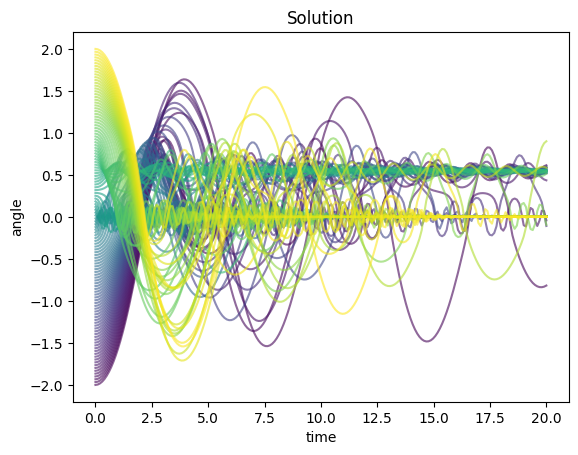

In [3]:
fig, ax = plt.subplots()

num_sims = 120
colors = plt.cm.viridis(np.linspace(0, 1, num_sims))

for i, phi in enumerate(np.linspace(-2, 2, num_sims)):
    pendulum = system(ic=[phi, 0], t_max=20)
    pendulum.add_magnet(magnet(pos=np.array([1, 1.2]), mom=np.array([0, 1.0])))
    # pendulum.add_magnet(magnet(pos=np.array([-0.5, 1.2]), mom=np.array([0, 0.8])))
    pendulum.add_magnet(magnet(pos=np.array([0, 1.2]), mom=np.array([0, -0.1])))
    pendulum.solve()
    pendulum.plot_solution(ax, colors[i])
    
    print(f"  {i}" if i < 10 else f" {i}" if i < 100 else i, end=" " if (i+1) % 10 else "\n")

ax.set_xlabel("time")
ax.set_ylabel("angle")
plt.show()


  0   1   2   3   4   5   6   7   8   9
 10  11  12  13  14  15  16  17  18  19
 20  21  22  23  24  25  26  27  28  29
 30  31  32  33  34  35  36  37  38  39
 40  41  42  43  44  45  46  47  48  49


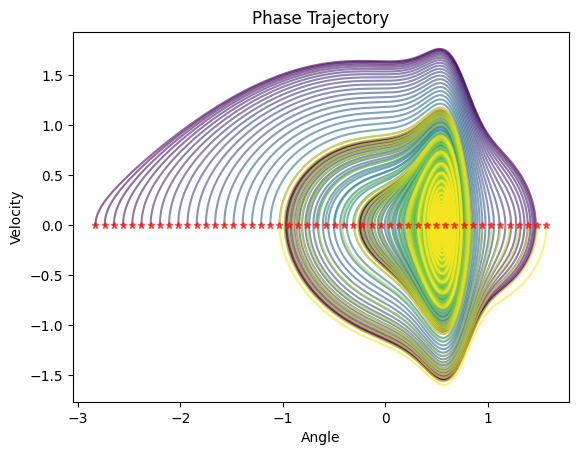

In [9]:
fig, ax = plt.subplots()

num_sims = 50
colors = plt.cm.viridis(np.linspace(0, 1, num_sims))

ics = []
for i, phi in enumerate(np.linspace(-0.9 * np.pi, 0.5 * np.pi, num_sims)):
    ics.append([phi, 0])
    pendulum = system(ic=ics[-1], dt=0.01, t_max=50)
    pendulum.add_magnet(magnet(pos=np.array([1, 1.2]), mom=np.array([0, 1.0])))
    # pendulum.add_magnet(magnet(pos=np.array([-0.5, 1.2]), mom=np.array([0, 0.8])))
    # pendulum.add_magnet(magnet(pos=np.array([0, 1.2]), mom=np.array([0, -0.1])))
    pendulum.solve()
    pendulum.plot_phase(ax, colors[i])
    
    print(f"  {i}" if i < 10 else f" {i}" if i < 100 else i, end=" " if (i+1) % 10 else "\n")

for ic in ics:
    ax.plot(ic[0], ic[1], 'r*', markersize=5, alpha=0.6)

plt.show()


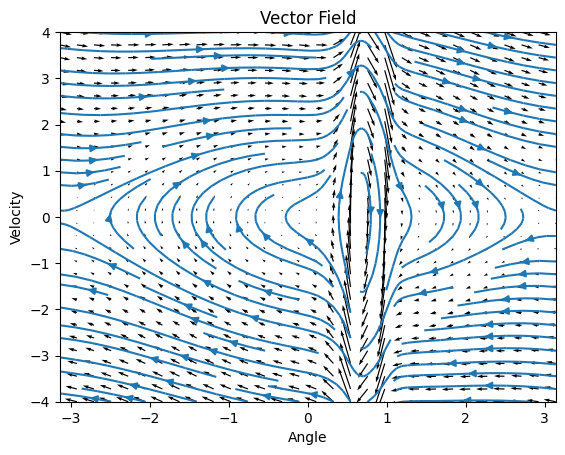

In [48]:
marcus = system(ic=[np.pi / 4, 0], dt=0.1, t_max=30)
# marcus = system(ic=[0.5 * np.pi, 0], dt=0.1, t_max=50)
# print(marcus.solve())
marcus.add_magnet(magnet(pos=np.array([1, 1]), mom=np.array([0.0, 1.0])))
# marcus.add_magnet(magnet(pos=np.array([-0.5, 1.2]), mom=np.array([0, 0.8])))
# marcus.add_magnet(magnet(pos=np.array([0, 1.2]), mom=np.array([0, -0.1])))


# marcus.solve()
# marcus.plot_solution()
# marcus.plot_phase()
marcus.plot_vectorfield(num_angles=30, num_velolcities=30)
plt.show()

1000
(1000, 2)


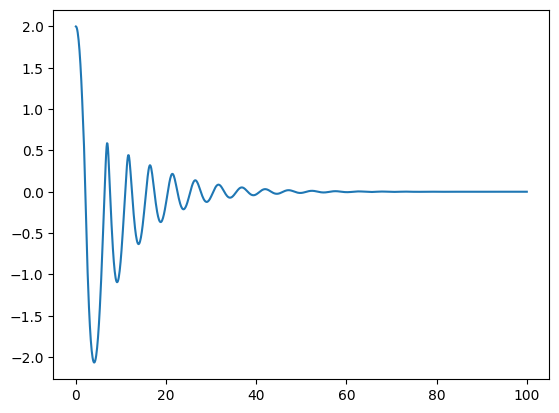

In [6]:
# def rhs(x, t):
#     return np.array([x[1], -np.sin(x[0])])

def rhs(phi, magnet_pos, t):
    m = 1
    g = 1
    l = 1
    mu0 = 1
    
    mpen = np.array([np.sin(phi[0]), np.cos(phi[0])])
    mmag = np.array([-0.5, 0])
    pos = l * mpen
    
    r = np.array(pos) - np.array(magnet_pos)
    r_norm = np.linalg.norm(r)
    r_hat = r / r_norm
    
    return np.array([
        phi[1], 
        # -np.sin(phi[0])
        - 0.2 * phi[1] - g / l * np.sin(phi[0]) - mu0 / (4 * np.pi * m * l * r_norm**5) * (15 * np.dot(mpen, r_hat) * np.dot(mmag, r_hat) - 3 * np.dot(mpen, mmag)) * (r[0] * np.cos(phi[0]) - r[1] * np.sin(phi[0]))
    ])


dt = 0.1
t_max = 100
num_steps = int(t_max / dt)
phi = []
phi.append(np.array([2, 0]))
magnet = np.array([1, 1])
# init_pos = np.linspace(-np.pi, np.pi, 100) * 0.5
# init_vel = np.zeros(100)
# phi.append([init_pos, init_vel])

for i in range(num_steps-1):
    t = (i + 1) * dt
    phi_next = rk4_step(phi[-1], magnet, t, dt, rhs)
    
    phi.append(phi_next)

phi = np.array(phi)
np.save("phi.npy", phi[:, 0])

print(num_steps)
print(phi.shape)
plt.plot(np.linspace(0, t_max, num_steps), phi[:, 0])
plt.show()
